# Method 1

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from image_utils import load_gray_img

In [14]:
# Parameters of Rician noise
img_path = "/mnt/big_disk/s.lin/RestormerRGBData/train/DFWB/BSD400/220003.jpg"
original_img = np.float64(load_gray_img(img_path)) / 255

H, W, C = original_img.shape[0], original_img.shape[1], original_img.shape[2]
N = H * W * C

In [15]:
np.random.seed(0)
v = 0 # shift from the center -> make the image more white
s = 50 # Standard deviation -> make the image from "noisy
rician_noise = np.random.normal(
    scale=s/255, size=(N, 2) # 2 = real and imaginary parts of complex-valued Rician
    ) + [[v/255,0]] # add v to all els in the real part, create a non-central Rician distribution
rician_noise = np.linalg.norm(rician_noise, axis=1) # compute L2-norm along dim = 1, shape = (N,)

gaussian_noise = np.random.normal(0, s/255., original_img.shape)

rician_noisy_img = original_img + rician_noise.reshape(original_img.shape)
gaussian_noise_img = original_img + gaussian_noise
mixed_noise_img = original_img + gaussian_noise + rician_noise.reshape(original_img.shape)


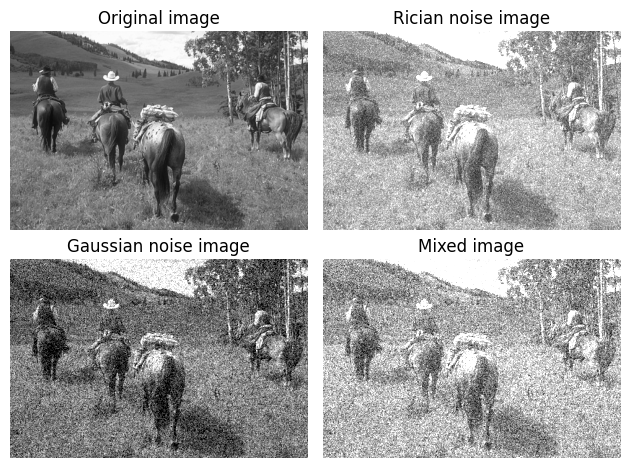

In [16]:
fig, axes = plt.subplots(2, 2)
# Display the first image in the left subplot (axes[0])
axes[0, 0].imshow(original_img, cmap='gray', vmin=0, vmax=1)
axes[0, 1].imshow(rician_noisy_img, cmap='gray', vmin=0, vmax=1)
axes[1, 0].imshow(gaussian_noise_img, cmap='gray', vmin=0, vmax=1)
axes[1, 1].imshow(mixed_noise_img, cmap='gray', vmin=0, vmax=1)

# Set titles for each subplot (optional)
axes[0, 0].set_title('Original image')
axes[0, 1].set_title('Rician noise image')
axes[1, 0].set_title('Gaussian noise image')
axes[1, 1].set_title('Mixed image')

# Hide axis ticks and labels for a cleaner display (optional)
axes[0, 0].axis('off')
axes[0, 1].axis('off')
axes[1, 0].axis('off')
axes[1, 1].axis('off')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

# Questions to discuss with Eili
1. N is the sample across pixel, not for only one pixel?
2. Reference?

# TODO
1. Use real brain image (IXI dataset), to estimate the sigma level
2. Set the shift (v) to 0
3. Apply to 2D images
4. Store 

# Method 2

In [37]:
import numpy as np

# Parameters of Rician noise
v = 8
s = 5

# Gray scale image dimensions
H, W = 128, 128

# Number of samples per pixel
N = 100

# Generate Rician noise samples for each pixel in the grayscale image
noise = np.random.normal(scale=s, size=(H, W, N, 2)) + np.full((H, W, N, 2), [v, 0])

# Calculate the magnitude of Rician noise for each pixel
noise_magnitude = np.linalg.norm(noise, axis=3)

# Take the mean of N samples for each pixel to get the final Rician noise for the grayscale image
rician_noise = np.mean(noise_magnitude, axis=2)

In [38]:
rician_noise

array([[10.32057529,  9.90984418, 10.066974  , ..., 10.09845049,
        10.4460652 , 10.19920767],
       [ 8.79056368,  9.52967939,  9.07302091, ..., 10.15508199,
         9.17751671,  9.63012882],
       [10.16181707, 10.05862421,  9.84385623, ..., 10.44595644,
         9.7228468 , 10.0233809 ],
       ...,
       [10.54777227,  9.92937074, 10.64965579, ...,  9.5763157 ,
         9.6559991 ,  9.32768184],
       [ 9.96873647, 10.27838466, 10.39459014, ..., 10.12249347,
         9.96246266,  9.43696047],
       [ 9.48879948,  9.82163874, 10.01793006, ...,  9.3105454 ,
        10.07164603, 10.40987715]])

# Noise estimation in DTI images
- Package: [DIPY](https://dipy.org/documentation/1.7.0/examples_built/04_preprocessing/piesno/#sphx-glr-examples-built-04-preprocessing-piesno-py)

In [82]:
import numpy as np
from dipy.denoise.noise_estimate import piesno
from dipy.data import get_fnames
from dipy.io.image import load_nifti, save_nifti
import matplotlib.pyplot as plt

In [83]:
# Fetch dataset
dwi_fname, dwi_bval_fname, dwi_bvec_fname = get_fnames('sherbrooke_3shell')
# data size should be (H,W,C,N)
data, affine = load_nifti(dwi_fname)

100%|██████████| 1/1 [00:00<00:00,  6.11 MB/s]


In [84]:
# Estimation algo.
sigma, mask = piesno(data, N=4, return_mask=True)

axial = data[:, :, data.shape[2] // 2, 0].T
axial_piesno = mask[:, :, data.shape[2] // 2].T

In [85]:
print('The noise standard deviation is sigma = ', sigma)
print('The std of the background is =',
      np.std(data[mask[..., :].astype(bool)]))

The noise standard deviation is sigma =  [7.263329  7.263329  7.263329  6.933178  7.263329  6.933178  6.933178
 6.933178  6.933178  6.933178  6.933178  7.263329  7.263329  6.933178
 7.5934806 7.263329  7.5934806 7.263329  7.263329  7.263329  7.5934806
 7.263329  7.5934806 7.5934806 7.263329  7.263329  7.5934806 7.5934806
 7.263329  7.263329  7.263329  7.5934806 7.263329  7.263329  7.263329
 7.263329  7.263329  7.263329  7.263329  7.263329  7.263329  7.263329
 7.263329  6.933178  7.263329  6.933178  6.933178  6.933178  6.933178
 6.933178  7.263329  7.263329  7.263329  7.263329  7.263329  7.263329
 7.263329  7.263329  7.263329  7.263329 ]
The std of the background is = 9.708311737182022


In [86]:
np.mean(sigma)

7.2303147